# Avellaneda-Stoikov

In [1]:
import sys
#sys.path.append("/home/paps/Documents/github/DRL4AMM/") # my version of this notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from stable_baselines3 import A2C, PPO, TD3
import stable_baselines3

from DRL4AMM.agents.Agent import Agent
from DRL4AMM.agents.AvellanedaStoikovAgent import AvellanedaStoikovAgent
from DRL4AMM.agents.BaselineAgents import RandomAgent, FixedActionAgent, FixedSpreadAgent
from DRL4AMM.gym.MarketMakingEnvironment import MarketMakingEnvironment
from DRL4AMM.gym.models import *
from DRL4AMM.gym.helpers.generate_trajectory import generate_trajectory
from DRL4AMM.gym.helpers.plotting import *
from DRL4AMM.rewards.RewardFunctions import InventoryAdjustedPnL, PnL
from DRL4AMM.gym.probability_models import *

In [2]:
%load_ext autoreload
%autoreload 2

## Random strategy

In [3]:
num_trajectories = 10

In [4]:
bm = BrownianMotionMidpriceModel(num_trajectories=num_trajectories)

In [5]:
bm.reset()

In [6]:
bm.current_state

array([[100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100],
       [100]])

In [7]:
bm.volatility

2.0

In [8]:
bm.update([],[],[])

In [9]:
bm.current_state.shape

(10, 1)

In [10]:
eff = ExponentialFillFunction(num_trajectories=num_trajectories)

In [11]:
actions = np.random.uniform(size =(num_trajectories,2))

In [12]:
eff.reset()

In [13]:
pam = PoissonArrivalModel(num_trajectories = num_trajectories)

In [15]:
pam.get_arrivals().sum()/20

0.1

In [18]:
as_env = MarketMakingEnvironment()
terminal_time = as_env.terminal_time
n_steps = as_env.n_steps
timestamps = np.linspace(0, terminal_time, n_steps + 1)

In [19]:
as_env.observation_space

Box([-1.08e+06 -1.00e+04  0.00e+00  9.20e+01], [1.08e+06 1.00e+04 1.00e+00 1.08e+02], (4,), float64)

In [20]:
as_env.max_inventory

10000

In [21]:
as_env.arrival_model.max_value

array([], shape=(1, 0), dtype=float64)

In [22]:
as_env.reset()

array([  0.,   0.,   0., 100.])

In [29]:
action = np.array([[1,1]])

In [35]:
action[0,1]

1

In [39]:
action

array([[1, 1]])

In [41]:
state = as_env.step(action)[0]

In [44]:
state.reshape((1,4))

array([[1.92913432e+00, 0.00000000e+00, 1.00000000e-02, 1.00145936e+02]])

In [19]:
np.array([as_env.max_cash, as_env.max_inventory, 0])

/tmp/ipykernel_291016/2765920901.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([as_env.max_cash, as_env.max_inventory, 0])


array([array([[1080000.]]), 10000, 0], dtype=object)

In [45]:
random = RandomAgent(as_env.action_space)

In [46]:
observations, actions, rewards = generate_trajectory(as_env,random)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

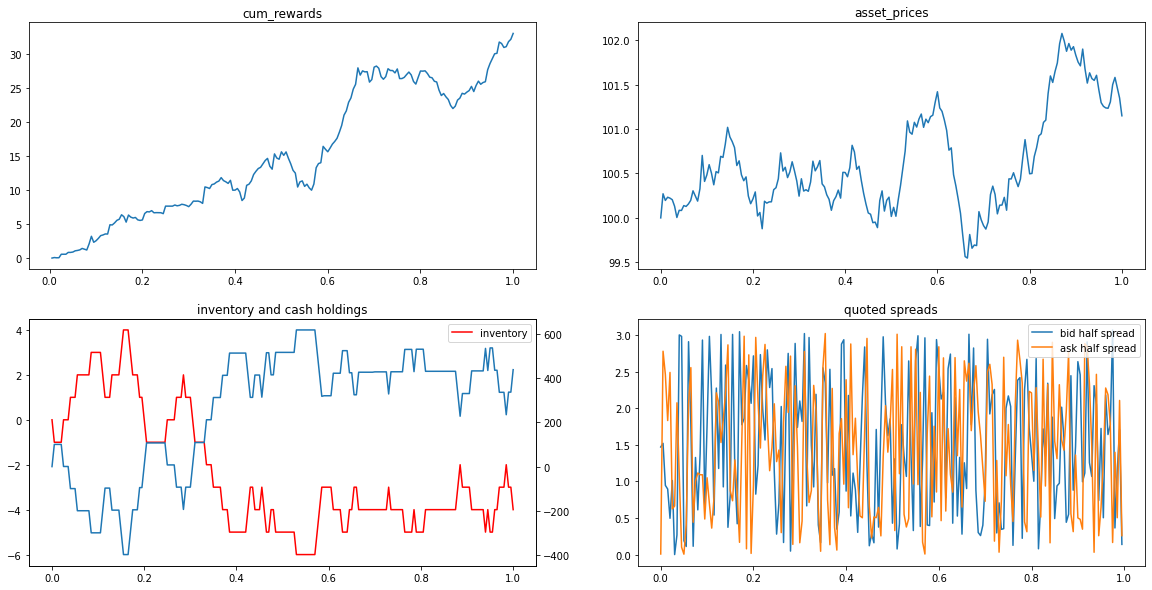

In [7]:
plot_trajectory(as_env, random)

## Fixed strategies

IndexError: index 1 is out of bounds for axis 0 with size 1

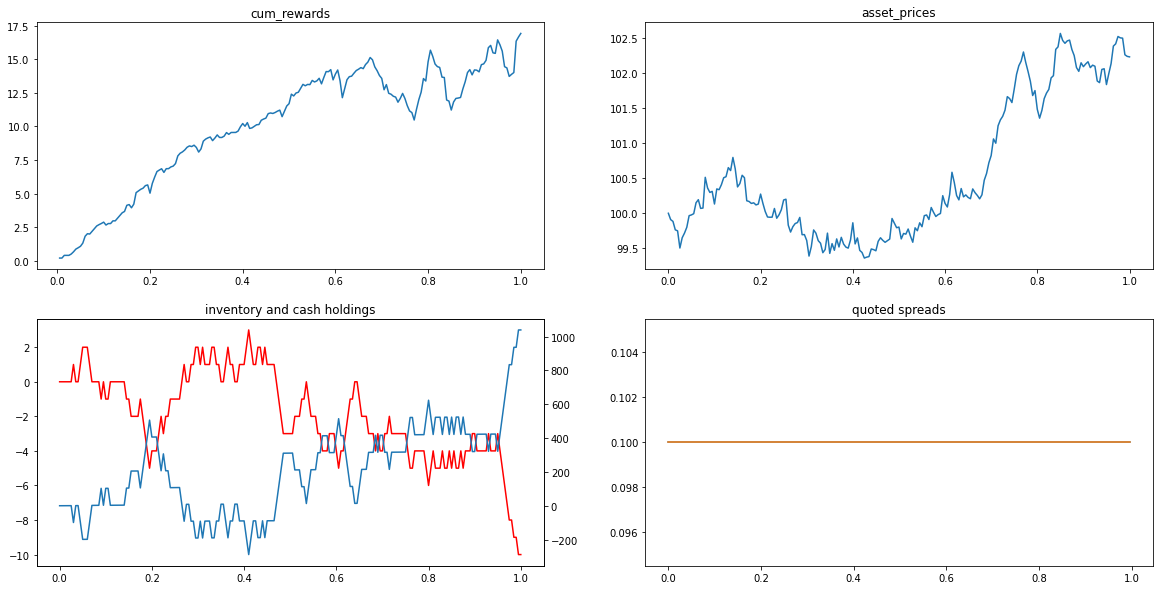

In [47]:
agent = FixedActionAgent(np.array([[0.1,0.1]]))
plot_trajectory(as_env,agent)

In [9]:
half_spreads = [0.25,0.5,1,2,4]

In [10]:
performance_dict = {}

for hs in half_spreads:
    np.random.seed(42)
    agent = FixedSpreadAgent(half_spread=hs)
    performance_dict[hs] = {}
    performance_dict[hs]["observations"], performance_dict[hs]["actions"], rewards = generate_trajectory(as_env,agent)
    performance_dict[hs]["cum_rewards"] = np.cumsum(rewards)

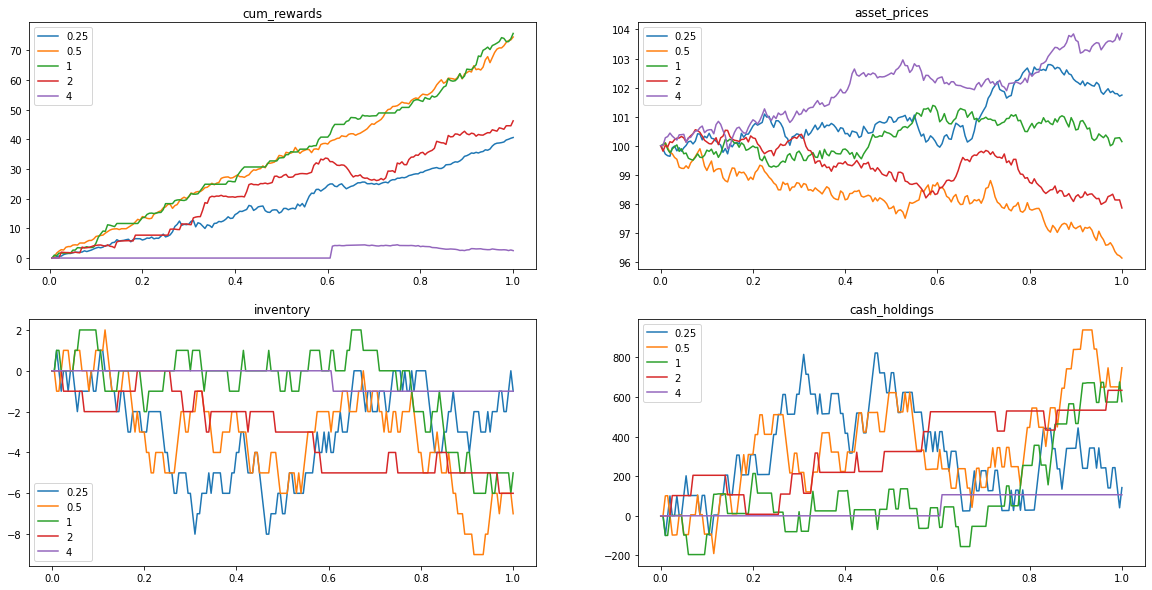

In [11]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

ax1.title.set_text("cum_rewards")
ax2.title.set_text("asset_prices")
ax3.title.set_text("inventory")
ax4.title.set_text("cash_holdings")

for hs in half_spreads:
    ax1.plot(timestamps[1:],performance_dict[hs]["cum_rewards"], label = hs)
    ax2.plot(timestamps,performance_dict[hs]["observations"][:,3], label = hs)
    ax3.plot(timestamps,performance_dict[hs]["observations"][:,1], label = hs)
    ax4.plot(timestamps,performance_dict[hs]["observations"][:,0], label = hs)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

# Optimal PnL fixed 

In [54]:
lambda_ = 40
as_terminal_time = 1.0
n_steps = int(lambda_ * as_terminal_time/0.1)
as_arrival = PoissonArrivalModel(intensity=[lambda_,lambda_], step_size=as_terminal_time/n_steps)
as_fill = ExponentialFillFunction(fill_exponent=1.5, step_size=as_terminal_time/n_steps)
as_midprice = BrownianMotionMidpriceModel(volatility=0.001, step_size=as_terminal_time/n_steps)
as_max_inv = 100
as_reward_func = PnL()

as_config = dict(terminal_time=as_terminal_time, 
                 midprice_model=as_midprice,
                 arrival_model=as_arrival, 
                 fill_probability_model=as_fill,
                 max_inventory=as_max_inv, 
                 n_steps = n_steps, 
                 reward_function=as_reward_func)

as_env = MarketMakingEnvironment(**as_config)

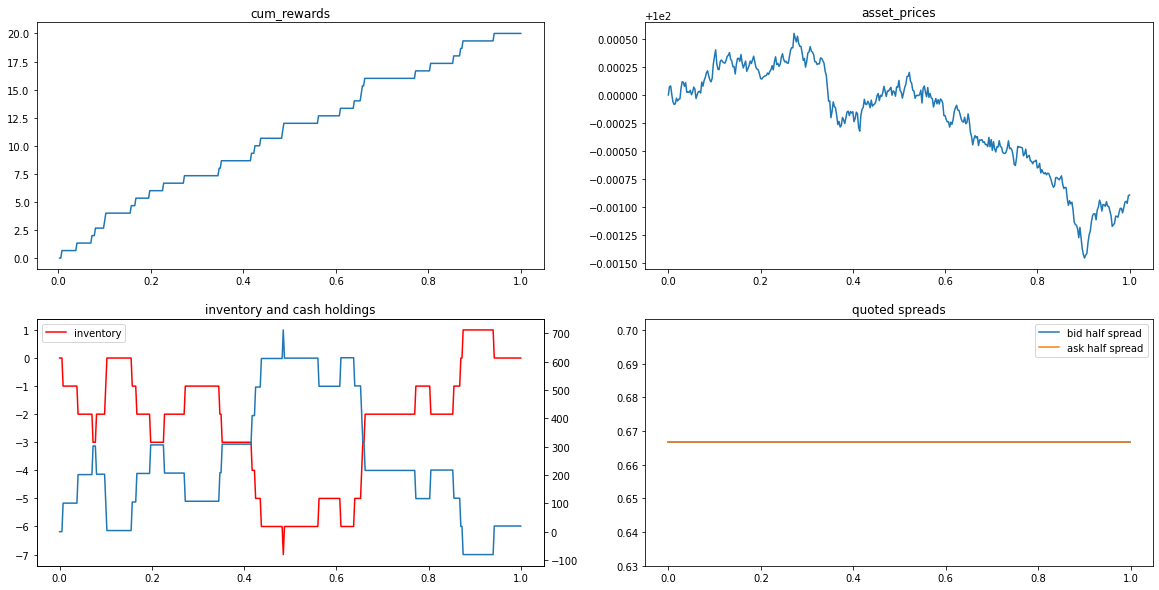

In [55]:
agent = FixedActionAgent(np.array([1/1.5,1/1.5]))
plot_trajectory(as_env,agent)

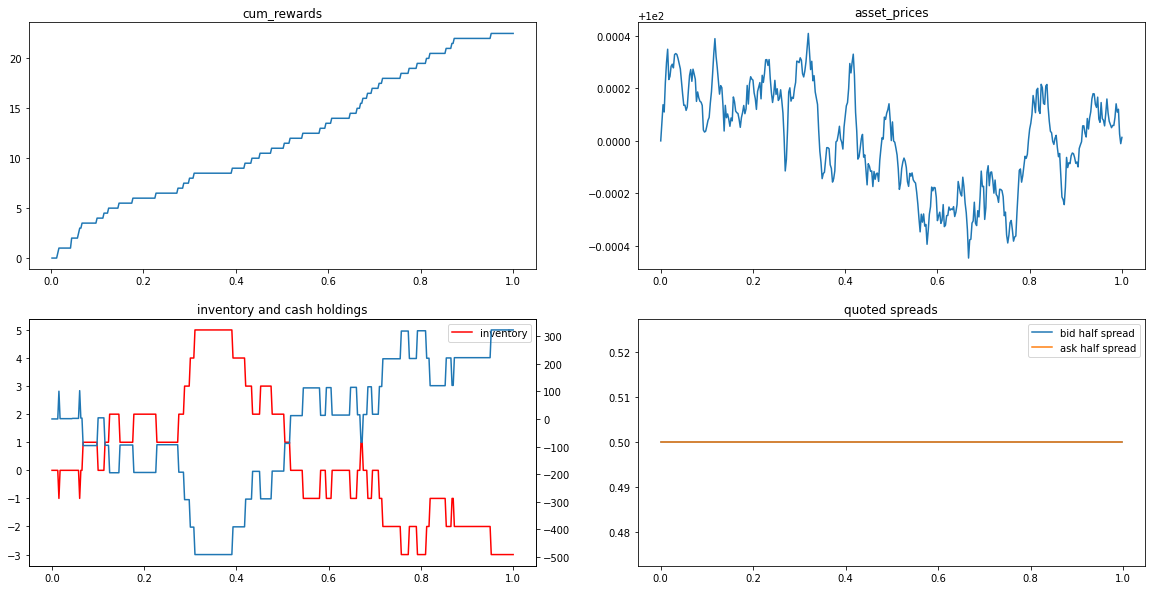

In [56]:
agent = FixedActionAgent(np.array([.5,.5]))
plot_trajectory(as_env,agent)

In [57]:
results, fig, _ = generate_results_table_and_hist(agent=agent,env=as_env,n_episodes=1_000)

In [58]:
results

,Mean spread,Mean PnL,Std PnL,Mean terminal inventory,Std terminal inventory
Inventory,1.0,19.001349,3.002793,1.0,0.0


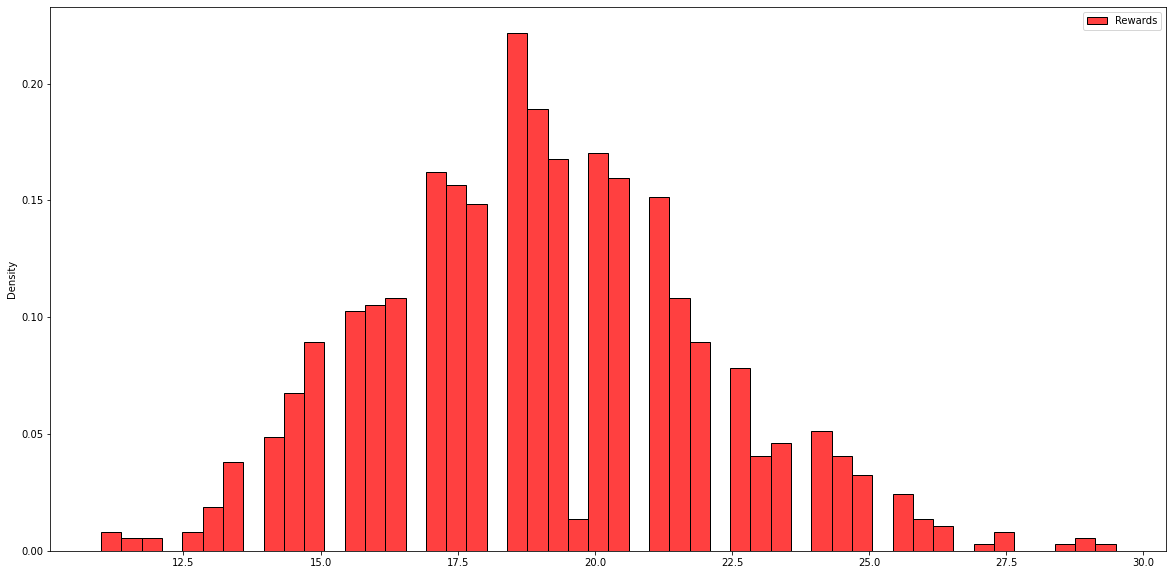

In [59]:
fig

# CarteaJaimungalAgent

In [60]:
from DRL4AMM.agents.BaselineAgents import CarteaJaimungalAgent

In [61]:
cj_agent = CarteaJaimungalAgent(phi = 0.0001, alpha=0.0001, max_inventory=100)

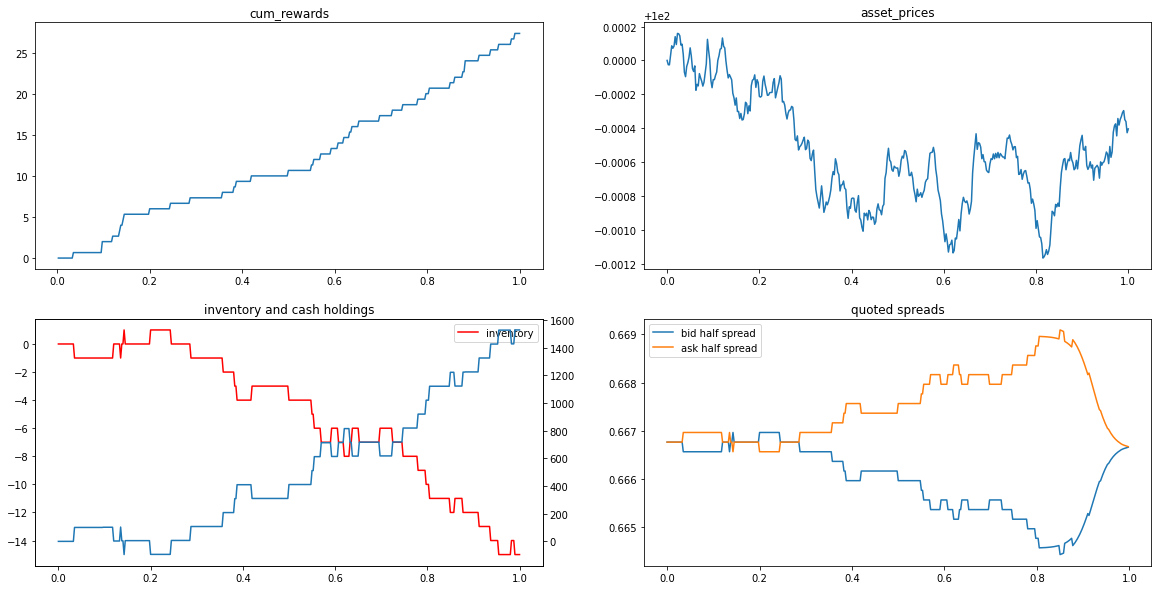

In [62]:
plot_trajectory(as_env,cj_agent)

In [67]:
CJ_arrival = PoissonArrivalModel(intensity=[1,1])
CJ_fill = ExponentialFillFunction(fill_exponent=100)
CJ_midprice = BrownianMotionMidpriceModel(volatility=0.01)
CJ_max_inv = 3
CJ_terminal_time = 30.0

CJ_env = MarketMakingEnvironment(terminal_time=30.0, 
                                 midprice_model=CJ_midprice,
                                 arrival_model=CJ_arrival, 
                                 fill_probability_model=CJ_fill,
                                 max_inventory=CJ_max_inv, n_steps = 30 * 1/0.1)
CJ_book_params = dict(phi=2E-4, alpha=0.0001, env=CJ_env, max_inventory=CJ_max_inv)

In [68]:
cj_agent = CarteaJaimungalAgent(**CJ_book_params)

In [69]:
timestamps = np.arange(0, CJ_terminal_time+0.1,0.1)

In [71]:
results, fig, _ = generate_results_table_and_hist(agent=cj_agent,env=CJ_env,n_episodes=1_000)

Clipping agent's cash from 300.13740410004505 to 300.12.
Clipping agent's inventory from 300.13740410004505 to 300.12.
Clipping agent's cash from 300.1264770052684 to 300.12.
Clipping agent's inventory from 300.1264770052684 to 300.12.


In [72]:
results

,Mean spread,Mean PnL,Std PnL,Mean terminal inventory,Std terminal inventory
Inventory,142.653792,0.02155,0.022066,30.0,0.0


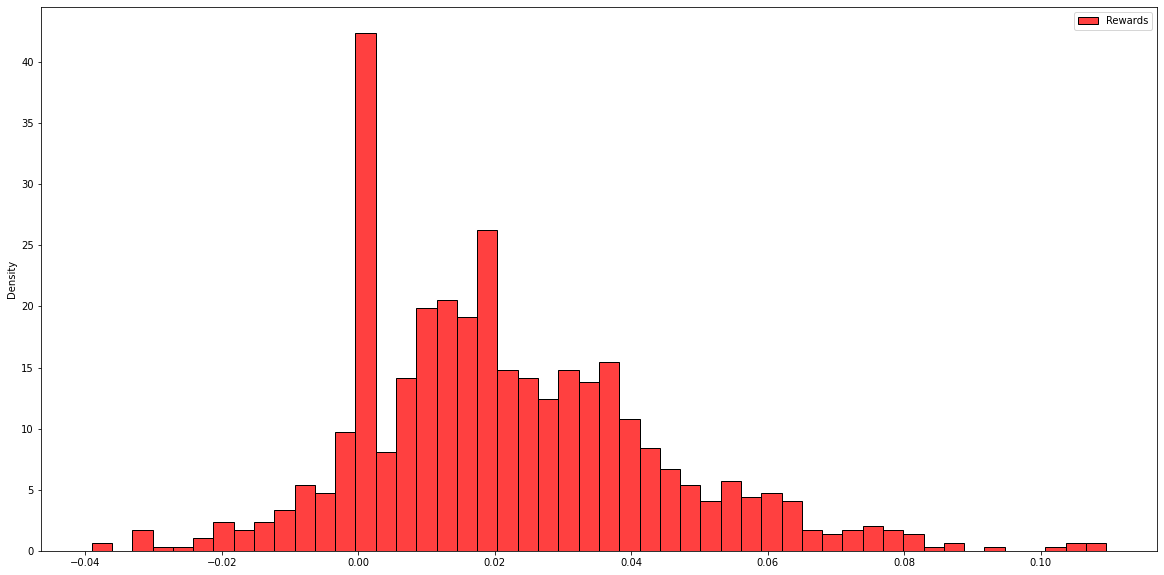

In [73]:
fig

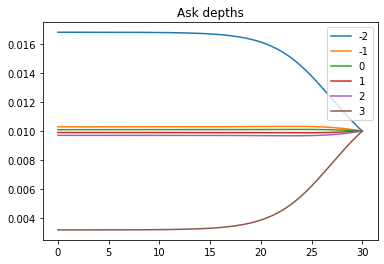

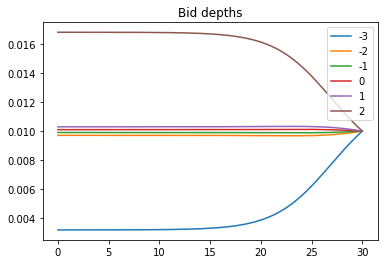

In [21]:
for inventory in range(-2, 4):
    plt.plot(timestamps, [cj_agent.get_action([100, inventory, ts])[1] for ts in timestamps], label = inventory)
plt.legend()
plt.title("Ask depths")
plt.show()

for inventory in range(-3, 3):
    plt.plot(timestamps, [cj_agent.get_action([100, inventory, ts])[0] for ts in timestamps], label = inventory)
plt.legend()
plt.title("Bid depths")
plt.show()

## Avellaneda-Stoikov Optimal Strategy

In [22]:
from DRL4AMM.gym.AvellanedaStoikovEnvironment import AvellanedaStoikovEnvironment
env = AvellanedaStoikovEnvironment(arrival_rate=140, volatility=2.0, fill_exponent=1.5, drift=0, terminal_time=1.0)

In [24]:
as_agent = AvellanedaStoikovAgent()

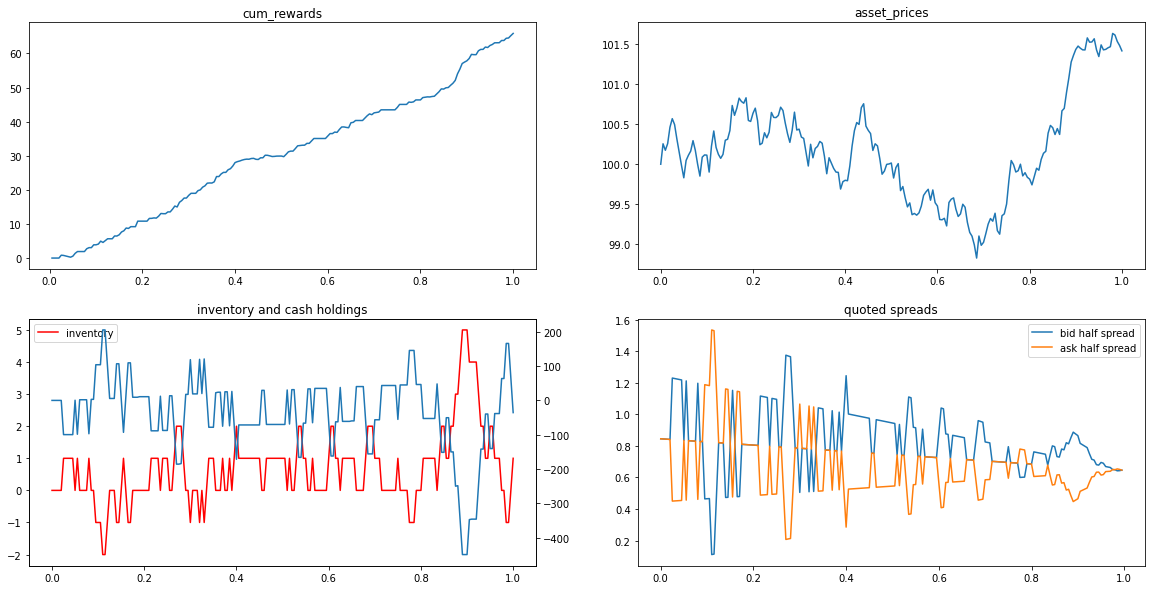

In [25]:
plot_trajectory(as_env, as_agent)

In [27]:
as_agent.volatility, as_agent.rate_of_arrival, as_agent.fill_exponent, as_agent.risk_aversion

(2.0, array([140., 140.]), 1.5, 0.1)

### Comparing the results to the Avellaneda Stoikov paper

In [33]:
results, fig, _ = generate_results_table_and_hist(agent=as_agent,env=as_env,n_episodes=1_000)

/home/paps/Documents/github/DRL4AMM/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


In [34]:
results

,Mean spread,Mean PnL,Std PnL,Mean terminal inventory,Std terminal inventory
Inventory,1.49177,64.987104,6.399662,1.0,0.0


These results look similar to Table 2 of Avellaneda and Stoikov. It is interesting that the agent **does** quote a negative spread sometimes, which could be interpreted as taking liquidity but then the model should possibly be changed.

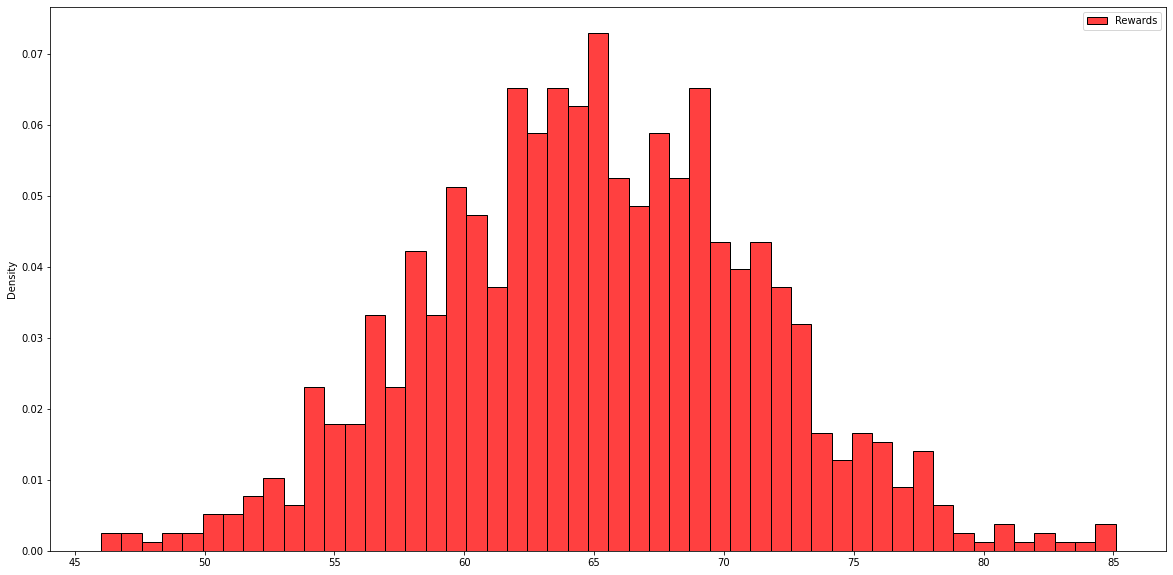

In [35]:
fig

## The effect of increasing risk aversion

In [36]:
risk_aversions = [0.01,0.1,0.5,1]

In [37]:
total_rewards_dict = dict()
for risk_aversion in risk_aversions:
    agent = AvellanedaStoikovAgent(risk_aversion=risk_aversion)
    _,_,total_rewards_dict[risk_aversion] = generate_results_table_and_hist(agent=agent,env=as_env,n_episodes=1000);   

/home/paps/Documents/github/DRL4AMM/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
/home/paps/Documents/github/DRL4AMM/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
/home/paps/Documents/github/DRL4AMM/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


In [38]:
colors = ["r", "g", "b", "c"]

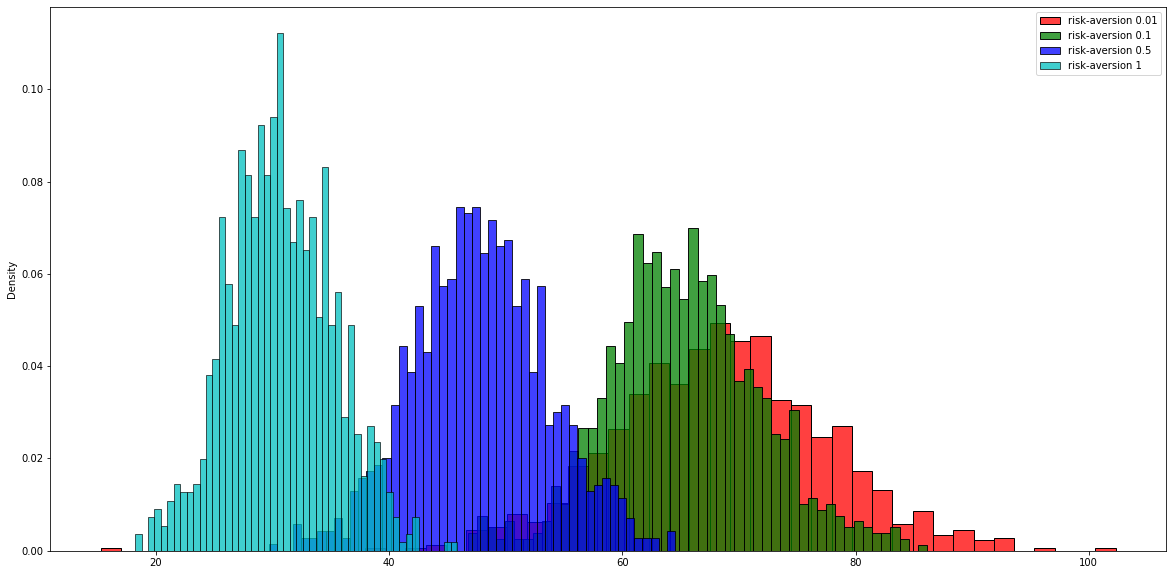

In [39]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
for risk_aversion, color in zip(risk_aversions,colors):
    sns.histplot(total_rewards_dict[risk_aversion], label=f"risk-aversion {risk_aversion}", stat = "density", bins = 50, ax=ax, color=color)
ax.legend()
plt.show()

**Note, it is hard to argue that the risk-averse agent is outperforming the non risk-averse agent in these cases...**

### Training a stable baselines agent on the Avellaneda-Stoikov gym environment

See separate notebook.